# Introduction
Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in. DO NOT USE either the MNIST digit recognition database or the iris data set. They’ve been worked on in very public ways very very many times and the code is easily available. (However, that code could be a useful resource to refer to).

## Import the Data and Cleaning

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
def load_lungs(data_path, categories, img_size):
    """Build dataset of x-rays
    Parameters:
    data_path(str): file location
    categories(str): folders within file location
    img_size(int): dimensions of image
    
    Returns:
    Tuple of the data and targets"""
    
    data = []
    
    for category in categories:
        #path to images
        path = os.path.join(data_path, category)
        # image identifer 0 for normal, 1 for pneumonia
        class_num = categories.index(category)
        
        for img in os.listdir(path):    
            # append each image to array apply grayscale
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            
            # uniform image shape for all x-rays
            new_array = cv2.resize(img_array, (img_size, img_size))
            new_array = normalize(new_array)
            data.append([new_array, class_num])
    
    # randomize the data to reduce bias
    random.shuffle(data)
    
    return data

In [3]:
def feature_target(dataset):
    """Append features and target variables
    Parameters:
    dataset(array): dataset that will be split
    
    Returns: X and y variables for modeling
    """
    X = []
    y = []

    for features, label in dataset:
        X.append(features)
        y.append(label)
    
    X = np.array(X)
    X = X.reshape(X.shape[0], -1)
    
    y = np.array(y)
    
    return X, y

In [4]:
start_time = time.time()
data_path = 'pneumonia_data/test'
categories = ['NORMAL', 'PNEUMONIA']
img_size = 750

train_set = load_lungs(data_path, categories, img_size)
print('Loaded {} x-rays.'.format(len(train_set)))

X_train, y_train = feature_target(train_set)
sm = SMOTE(random_state=1, ratio=1)
X_train, y_train = sm.fit_sample(X_train, y_train)

print("\n--- %s seconds ---" % (time.time() - start_time))

Loaded 624 x-rays.

--- 62.9326012134552 seconds ---


In [5]:
start_time = time.time()
data_path = 'pneumonia_data/val'

test_set = load_lungs(data_path, categories, img_size)
print('Loaded {} x-rays.'.format(len(test_set)))

X_test, y_test = feature_target(test_set)
print("\n--- %s seconds ---" % (time.time() - start_time))

Loaded 16 x-rays.

--- 0.25293517112731934 seconds ---


In [6]:
start_time = time.time()

rbm = BernoulliRBM(random_state=1, learning_rate=.1)
logistic = linear_model.LogisticRegression()
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

logistic = logistic.fit(X_train, y_train)
classifier = classifier.fit(X_train, y_train)
print('Training Set Fitted')

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Set Fitted


C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)
print('Test Set Predicted')

# Print results of test and train data
print('\nAccuracy Score of Training Set: {}\n'.format(accuracy_score(y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(y_test, pred_test)))
print("\n--- %s seconds ---" % (time.time() - start_time))  

Test Set Predicted

Accuracy Score of Training Set: 0.5

Accuracy Score of Test Set: 0.5

--- 3725.2175023555756 seconds ---


(780,) (780,)
[1 1 1 1 0 0 1 0 0 0] [0 0 0 0 0 0 0 0 0 0]


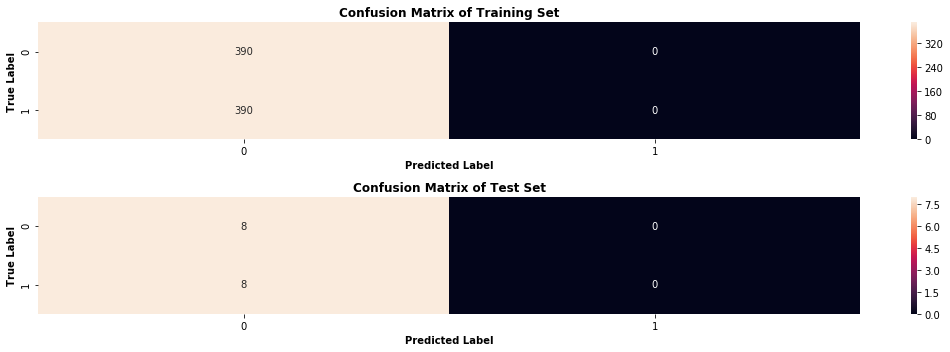

In [8]:
# create heatmap of confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt='g')

print(y_train.shape, pred_train.shape)
print(y_train[:10], pred_train[:10])

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Training Set', fontweight='bold')

plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()